In [2]:
import numpy as np

import torch

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

### 데이터 작업하기

In [29]:
train_data = datasets.FashionMNIST(
                                    root = 'data',
                                    train = True,
                                    download = True,
                                    transform = ToTensor(),
)

test_data = datasets.FashionMNIST(
                                    root = 'data',
                                    train = False,
                                    download = True,
                                    transform = ToTensor(),
)

batch_size = 64

# 데이터로더 생성
train_dataloader = DataLoader(train_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
    print(f'Shape of X [N, C, H, W]: {X.shape}')
    print(f'Shape of y: {y.shape} ({y.dtype})')
    
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) (torch.int64)


### 모델 만들기

In [30]:
device = 'cpu'
print(f'Using {device}: device')

# model define
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() # nn.Module 클래스를 상속 클래스로 가져온다.
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
                                                nn.Linear(28  * 28, 512),
                                                nn.ReLU(),
                                                nn.Linear(512, 512),
                                                nn.ReLU(),
                                                nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        
        logits = self.linear_relu_stack(x)
        
        return logits
    

model = NeuralNetwork().to(device)
print(model)

Using cpu: device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### 모델 매개변수 최적화하기

In [31]:
# 손실함수
loss_fn = nn.CrossEntropyLoss()

# 최적화 함수
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

In [42]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y) #  nn.CrossEntropyLoss()(pred, y)
        
        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')
            
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.eval()
    
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches # 배치 단위로 평균 값을 구하는 것
    correct /= size
    
    print(f'Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f}\n')

In [43]:
epochs = 5

for t in range(epochs):
    print(f'Epoch {t+1}\n--------------------------')
    
    train(train_dataloader, model, loss_fn, optimizer)
    test(train_dataloader, model, loss_fn)
    
print('done')

Epoch 1
--------------------------
loss: 1.921444 [    0/60000]
loss: 1.900442 [ 6400/60000]
loss: 1.776031 [12800/60000]
loss: 1.824465 [19200/60000]
loss: 1.727718 [25600/60000]
loss: 1.663459 [32000/60000]
loss: 1.688415 [38400/60000]
loss: 1.581881 [44800/60000]
loss: 1.609367 [51200/60000]
loss: 1.508349 [57600/60000]
Test Error: 
 Accuracy: 63.6%, Avg loss: 1.515429

Epoch 2
--------------------------
loss: 1.581369 [    0/60000]
loss: 1.555866 [ 6400/60000]
loss: 1.397086 [12800/60000]
loss: 1.476476 [19200/60000]
loss: 1.360474 [25600/60000]
loss: 1.344947 [32000/60000]
loss: 1.366002 [38400/60000]
loss: 1.280496 [44800/60000]
loss: 1.321052 [51200/60000]
loss: 1.225077 [57600/60000]
Test Error: 
 Accuracy: 65.0%, Avg loss: 1.239481

Epoch 3
--------------------------
loss: 1.319220 [    0/60000]
loss: 1.310707 [ 6400/60000]
loss: 1.138401 [12800/60000]
loss: 1.250935 [19200/60000]
loss: 1.121141 [25600/60000]
loss: 1.142994 [32000/60000]
loss: 1.173743 [38400/60000]
loss: 1.09

### 모델 저장 및 불러오기

In [44]:
torch.save(model.state_dict(), './data/pytorch_basic_model.pth')
print('Saved PyTorch Model State to pytorch_basic_model.pth')

Saved PyTorch Model State to pytorch_basic_model.pth


In [47]:
model = NeuralNetwork()
model.load_state_dict(torch.load('./data/pytorch_basic_model.pth'))

<All keys matched successfully>

In [48]:
classes = [
            "T-shirt/top",
            "Trouser",
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot",
]

model.eval()

x, y = test_data[0][0], test_data[0][1]

with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"



--------------------------------


# 텐서 (Tensor)

### 텐서 초기화

In [52]:
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)

print(data, type(data))
print(x_data, x_data.shape, type(x_data))

[[1, 2], [3, 4]] <class 'list'>
tensor([[1, 2],
        [3, 4]]) torch.Size([2, 2]) <class 'torch.Tensor'>


torch.tensor 메서드를 통해, 리스트 타입의 데이터를 텐서 타입으로 변경한다. 텐서의 경우 형태(shape)을 가진다.

In [59]:
data = [[1, 2], [3, 4]]
np_array = np.array(data)

x_np_1 = torch.tensor(np_array)
x_np_2 = torch.from_numpy(np_array)

print(data, type(data))
print(np_array, type(np_array))
print(x_np_1, x_np_1.shape, type(x_np_1))
print(x_np_2, x_np_2.shape, type(x_np_2))

[[1, 2], [3, 4]] <class 'list'>
[[1 2]
 [3 4]] <class 'numpy.ndarray'>
tensor([[1, 2],
        [3, 4]], dtype=torch.int32) torch.Size([2, 2]) <class 'torch.Tensor'>
tensor([[1, 2],
        [3, 4]], dtype=torch.int32) torch.Size([2, 2]) <class 'torch.Tensor'>


numpy array 데이트를 텐서로 변경할 경우, 리스트를 변경하던 것과 같이 torch.tensor 메서드로도 변경이 가능하고

torch.from_numpy 메서드를 통해서도 변경이 가능하다.

In [74]:
x_ones = torch.ones_like(x_data)

print(f'Org Tensor:\n {x_data}')
print(f'Ones Tensor:\n {x_ones}')

x_rand_float = torch.rand_like(x_data, dtype = torch.float) # 텐서를 구성하는 데이터의 타입을 변경할 경우, 명시해주어야 한다.

print(f'Random Tensor:\n {x_rand_float}')

Org Tensor:
 tensor([[1, 2],
        [3, 4]])
Ones Tensor:
 tensor([[1, 1],
        [1, 1]])
Random Tensor:
 tensor([[0.2364, 0.9786],
        [0.0341, 0.1483]])


In [76]:
shape = (2, 3, 1)

rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f'Random Tensor: \n {rand_tensor}\n')
print(f'Ones Tensor: \n {ones_tensor}\n')
print(f'Zeros Tensor: \n {zeros_tensor}')

Random Tensor: 
 tensor([[[0.6306],
         [0.7636],
         [0.5492]],

        [[0.5855],
         [0.1014],
         [0.1427]]])

Ones Tensor: 
 tensor([[[1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.]]])

Zeros Tensor: 
 tensor([[[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]]])


In [85]:
shape = (2, 3, )

rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f'Random Tensor: \n {rand_tensor}\n')
print(f'Ones Tensor: \n {ones_tensor}\n')
print(f'Zeros Tensor: \n {zeros_tensor}')

Random Tensor: 
 tensor([[0.6434, 0.6479, 0.2607],
        [0.0702, 0.3801, 0.1208]])

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]])

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


### 텐서의 속성

In [92]:
tensor = torch.rand(3, 4, 2)

print(f'Shape of tensor: {tensor.shape}')
print(f'Datatype of tensor: {tensor.dtype}')
print(f'Device tensor is stored on: {tensor.device}')

Shape of tensor: torch.Size([3, 4, 2])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


### 텐서의 연산

In [94]:
# GPU가 존재하면 텐서를 이동한다.
if torch.cuda.is_available():
    tensor = tensor.to('cuda')

In [96]:
tensor = torch.ones(4, 4)

print(tensor)
print(f'First row: {tensor[0]}')
print(f'First column: {tensor[:, 0]}')
print(f'Last column: {tensor[:, -1]}')

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])


In [97]:
tensor[:, 1] = 0 # 1열 값을 전부 0으로 변경

print(tensor)
print(f'First row: {tensor[0]}')
print(f'First column: {tensor[:, 0]}')
print(f'Last column: {tensor[:, -1]}')

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
First row: tensor([1., 0., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])


In [114]:
print(torch.cat([tensor, tensor], dim = 0).shape)
print(torch.cat([tensor, tensor], dim = 0))

print(torch.cat([tensor, tensor], dim = 1).shape)
print(torch.cat([tensor, tensor], dim = 1))

torch.Size([8, 4])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
torch.Size([4, 8])
tensor([[1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1.]])


In [124]:
# 지정해준 차원(dim 값)에 데이터를 stack 하는 것

print(torch.stack([tensor, tensor], dim = 1).shape)
print(torch.stack([tensor, tensor], dim = 1))

torch.Size([4, 2, 4])
tensor([[[1., 0., 1., 1.],
         [1., 0., 1., 1.]],

        [[1., 0., 1., 1.],
         [1., 0., 1., 1.]],

        [[1., 0., 1., 1.],
         [1., 0., 1., 1.]],

        [[1., 0., 1., 1.],
         [1., 0., 1., 1.]]])


In [130]:
# 텐서 간의 행렬 곱
# @ = matmul 같은 기능

y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out = y3)

tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])

In [135]:
# 요소별 곱

z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out = z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [145]:
# 텐서 합

agg = tensor.sum()
agg_item = agg.item()

print(agg, type(agg))
print(agg_item, type(agg_item))

tensor(12.) <class 'torch.Tensor'>
12.0 <class 'float'>


### NumPy 변환

In [149]:
t = torch.ones(5)
print(f't: {t}')

n = t.numpy()
print(f'n: {n}')

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


In [150]:
n = np.ones(5)
print(f'n: {n}')

t = torch.from_numpy(n)
print(f't: {t}')

n: [1. 1. 1. 1. 1.]
t: tensor([1., 1., 1., 1., 1.], dtype=torch.float64)


# Dataset & DataLoader

- https://pytorch.org/vision/stable/datasets.html
- https://pytorch.org/audio/stable/datasets.html
- https://pytorch.org/text/stable/datasets.html

In [3]:
train_data = datasets.FashionMNIST(
                                    root = 'data',
                                    train = True,
                                    download = True,
                                    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
                                    root = 'data',
                                    train = False,
                                    download = True,
                                    transform = ToTensor()
)

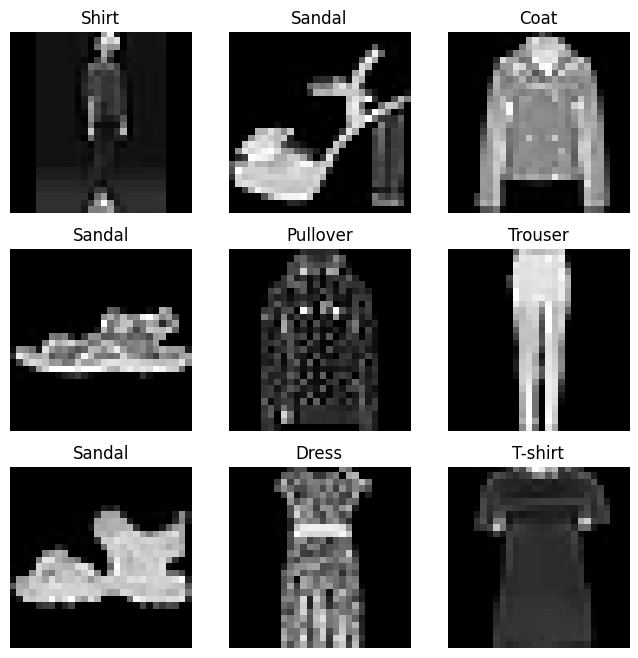

In [4]:
labels_map = {
                0: 'T-shirt',
                1: 'Trouser',
                2: 'Pullover',
                3: 'Dress',
                4: 'Coat',
                5: 'Sandal',
                6: 'Shirt',
                7: 'Sneaker',
                8: 'Bag',
                9: 'Ankle Boot'    
}

figure = plt.figure(figsize = (8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1, )).item()
    img, label = train_data[sample_idx]
    
    figure.add_subplot(rows, cols, i)
    
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap = 'gray')
    
plt.show()

### 사용자 정의 데이터셋 만들기

In [5]:
import os
import pandas as pd

from torchvision.io import read_image

In [ ]:
class CustomImageDataset(Dataset)

# Modeling

In [10]:
import os
import torch

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
device = 'cpu'

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
                                                nn.Linear(28 * 28, 512),
                                                nn.ReLU(),
                                                nn.Linear(512, 512),
                                                nn.ReLU(),
                                                nn.Linear(512, 10),
        )
        
    # forward 함수는 모델을 선언하면 자동으로 실행된다.
    def forward(self, x):
        x = self.flatten(x)
        
        logits = self.linear_relu_stack(x)
        
        return logits

In [17]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [18]:
X = torch.rand(1, 28, 28, device = device)

logits = model(X)
pred_probab = nn.Softmax(dim = 1)(logits)
y_pred = pred_probab.argmax(1)

In [19]:
print(f'Predicted class: {y_pred}')

Predicted class: tensor([8])


### 모델 계층

In [26]:
# 미니 배치
input_image = torch.rand(3, 28, 28)
print(input_image.size())

torch.Size([3, 28, 28])


In [27]:
flatten = nn.Flatten()
flat_image = flatten(input_image)

print(flat_image.size())

torch.Size([3, 784])


In [29]:
layer1 = nn.Linear(in_features = 28 * 28, out_features = 20)
hidden1 = layer1(flat_image)

print(hidden1.size())

torch.Size([3, 20])


In [47]:
print(f'Before ReLU: {hidden1}\n\n')

hidden1 = nn.ReLU()(hidden1)

print(f'After ReLU: {hidden1}')

Before ReLU: tensor([[-0.0155, -0.0997,  0.2322, -0.0447,  0.1359,  0.2476, -0.2504,  0.1350,
         -0.3536,  0.4356, -0.0137, -0.1336,  0.2654, -0.0573, -0.0494,  0.0010,
          0.1425,  0.0519,  0.1827,  0.3654],
        [-0.0948,  0.2506,  0.2493, -0.4572,  0.1355, -0.0049, -0.1472, -0.1333,
         -0.8852,  0.3066, -0.1430, -0.1045,  0.1270,  0.0070, -0.1197, -0.1853,
          0.2348,  0.0331,  0.1643, -0.0478],
        [ 0.0256, -0.0724,  0.2674, -0.4136, -0.0404, -0.1888, -0.2129, -0.2057,
         -0.7877,  0.3558, -0.3764, -0.1464,  0.0997, -0.2069, -0.4644, -0.0260,
          0.2247,  0.1765,  0.4162,  0.4185]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.0000, 0.2322, 0.0000, 0.1359, 0.2476, 0.0000, 0.1350, 0.0000,
         0.4356, 0.0000, 0.0000, 0.2654, 0.0000, 0.0000, 0.0010, 0.1425, 0.0519,
         0.1827, 0.3654],
        [0.0000, 0.2506, 0.2493, 0.0000, 0.1355, 0.0000, 0.0000, 0.0000, 0.0000,
         0.3066, 0.0000, 0.0000, 0.1270, 0.0070, 0.00

In [48]:
seq_modules = nn.Sequential(
                            flatten,
                            layer1,
                            nn.ReLU(),
                            nn.Linear(20, 10)
)

input_image = torch.rand(3, 28, 28)
logits = seq_modules(input_image)

In [50]:
softmax = nn.Softmax(dim = 1)
pred_probab = softmax(logits)

### 모델 매개변수 확인

In [52]:
for name, param in model.named_parameters():
    print(f'Layer: {name} | Size: {param.size} | Values: {param[:2]}\n')

Layer: linear_relu_stack.0.weight | Size: <built-in method size of Parameter object at 0x7f700652aea0> | Values: tensor([[ 1.3846e-02, -2.4204e-02,  2.9069e-02,  ...,  1.2153e-02,
         -2.6698e-04, -2.9304e-02],
        [-3.2597e-02, -2.2273e-02,  3.6423e-03,  ...,  8.7197e-05,
          1.2395e-02, -3.3895e-04]], grad_fn=<SliceBackward0>)

Layer: linear_relu_stack.0.bias | Size: <built-in method size of Parameter object at 0x7f700652acc0> | Values: tensor([ 0.0312, -0.0265], grad_fn=<SliceBackward0>)

Layer: linear_relu_stack.2.weight | Size: <built-in method size of Parameter object at 0x7f700652ab30> | Values: tensor([[-0.0230, -0.0155, -0.0393,  ..., -0.0372, -0.0098, -0.0258],
        [-0.0318,  0.0297,  0.0089,  ...,  0.0250,  0.0376,  0.0006]],
       grad_fn=<SliceBackward0>)

Layer: linear_relu_stack.2.bias | Size: <built-in method size of Parameter object at 0x7f700652ac70> | Values: tensor([ 0.0347, -0.0095], grad_fn=<SliceBackward0>)

Layer: linear_relu_stack.4.weight |